In [1]:
## Goal: present the SED 
import sys
import numpy as np
import astropy.table as table
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as signal
from scipy.interpolate import BSpline, make_lsq_spline
try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')

#import snelib19odp.const as consti
import snelib19odp.blackbody as bb

In [2]:
# load the swift-uvot observations
uvot=table.Table.read('../data/uvot_phot.txt', format='ascii')
uvot['mjd'] = uvot['JD'] - 2400000.5
idx = uvot['AB_MAG'] < uvot['AB_MAG_LIM']-3*uvot['AB_MAG_ERR']
#uvot[idx]
#uvot
UVOT_FILTERS = {
    'UVW2': (2085.73, 2.50225e-8, 667.73),
    'UVM2': (2245.78, 2.1583e-8, 533.85),
    'UVW1': (2684.14, 1.5109e-8, 801.92),
    'U': (3520.95, 8.78064e-9, 662.50),
    'B': (4346.25, 5.76258e-9, 866.22),
    'V': (5411.43, 3.71725e-9, 655.67)
}
uvot


<Table length=30>
        JD         FILTER  AB_MAG ... AB_MAG_LIM  EXPOSURE        mjd        
     float64        str4  float64 ...  float64    float64       float64      
------------------ ------ ------- ... ---------- --------- ------------------
 2458718.671532725   UVW1 21.1707 ...    21.2422   157.237 58718.171532724984
 2458718.672967196      U 20.4926 ...    20.6174   78.5208  58718.17296719598
2458718.6739443885      B 18.9096 ...    19.9058   78.5099 58718.173944388516
 2458718.676326107   UVW2 22.8054 ...    22.0495  314.7237  58718.17632610677
 2458718.678691991      V 18.5903 ...     18.981   78.5099  58718.17869199114
2458718.6864458714   UVM2 22.4146 ...    22.7858 1232.0625  58718.18644587137
2458719.9762494587   UVW1 21.2914 ...    21.7586  314.4848 58719.476249458734
2458719.9776854618      U 20.6638 ...     21.086  157.0415  58719.47768546175
2458719.9786609937      B 18.7056 ...    20.3376  157.0089 58719.478660993744
 2458719.981038498   UVW2 22.2051 ...    22.5072  629.4365  58719.48103849823
               ...    ...     ... ...        ...       ...                ...
 2458722.466636421      B 18.0553 ...    19.9228   83.4398  58721.96663642116
2458722.4696758366   UVW2 21.6442 ...    22.2635  420.0442  58721.96967583662
2458722.4726960976      V 17.4948 ...    19.0146   83.4398  58721.97269609757
 2458722.477111435   UVM2 22.5054 ...     22.325   659.331  58721.97711143503
2458722.9923105906   UVW1 21.4382 ...    21.5357  228.8485  58722.49231059058
2458722.9930524146      U 19.3981 ...    20.5972   76.3055  58722.49305241462
2458722.9935571323      B 17.7854 ...    19.8712   76.3164 58722.493557132315
2458722.9953806284   UVW2 22.3304 ...    22.2042  381.4299  58722.49538062839
 2458722.996366376      V 17.3002 ...    18.9591   76.3381  58722.49636637606
2458722.9991869847   UVM2 21.9423 ...    22.2645  603.0602  58722.49918698473

In [3]:
# load the ztflc observations
ztflc = table.Table.read('../data/ztflc_forcefit.h5')
ztflc['mag'] = -2.5*np.log10(ztflc['ampl']) + ztflc['magzp']
ztflc['rel_err'] = ztflc['ampl.err']/np.abs(ztflc['ampl'])

ZTF_FILTERS = {
    'g': (4722.74, 4.88043e-9, 1320.55),
    'r': (6339.61, 2.70846e-9, 1557.05),
    'i': (7886.13, 1.75033e-9, 1522.14)
}

ztflc

<ipython-input-3-5973efdf9739>:3: RuntimeWarning: invalid value encountered in log10
  ztflc['mag'] = -2.5*np.log10(ztflc['ampl']) + ztflc['magzp']


<Table length=233>
      sigma             sigma.err      ...        rel_err       
     float64             float64       ...        float64       
------------------ ------------------- ... ---------------------
14.472378378366585  0.4071467539468257 ...  0.028146866282823837
 42.79852101731375   1.254812629594178 ...    0.6018744829054432
 5.019048789272439  0.1453871691987656 ...  0.004544238719329836
 10.72947163499287 0.30589623511701863 ...    0.6321239283734909
 9.184468245595319  0.2636963406672404 ...  0.004526293767055892
10.144355640294936 0.28890516819398504 ...   0.21861722509623394
  6.79480734831998 0.18939070960168858 ...  0.007791430934979799
27.448735561223543  0.7884957167202911 ...  0.018483838789756613
 7.826544860818549 0.22435069687094494 ...  0.012197473917673422
  5.14333568356807 0.14392711628327534 ...     1.607402095021307
               ...                 ... ...                   ...
13.004702445429384 0.37086223104520827 ...    1.4025174318991855
 7.644904310915697 0.22698969397311558 ...   0.08376959636952203
 7.754619449369814 0.22235180405527463 ...  0.005755136566006104
10.157528553702546 0.28721683436054907 ... 0.0047011600710358484
12.328326975949324  0.3508564506937175 ...     5.389869153786896
 38.67995149442595   1.130666960923682 ...    2.0593838516931733
15.083117302180508 0.43154350803086433 ...    0.4198317045233743
21.702311848491192  0.6198597401396926 ...  0.014148046400781388
 11.17162574053698 0.31134426347099214 ...    0.6533575786469288
 4.429017756876249 0.13089623320578814 ...    0.9197663282844273

In [4]:
ztfint = pd.read_hdf('../products/lc_interpolated_per_ins.h5')
ztfint.iloc[2]#['mag_"g"_ZTF']

mag_"g"_ZTF        18.482736
magerr_"g"_ZTF      0.029957
mag_"i"_ZTF        18.891938
magerr_"i"_ZTF      0.092034
mag_"r"_ZTF        18.477867
magerr_"r"_ZTF      0.019041
mag_"g"_SEDM       17.870803
magerr_"g"_SEDM     0.201954
mag_"i"_SEDM       18.259265
magerr_"i"_SEDM     0.155399
mag_"r"_SEDM       18.630171
magerr_"r"_SEDM     0.000006
mag_"u"_SEDM       17.934097
magerr_"u"_SEDM     0.000081
Name: 58718.38879999984, dtype: float64

In [5]:
redshift = 0.014353

def load(fname):
    x = table.Table.read(fname, format='ascii')
    x['wavelength'] /= (1+redshift)
    return x

spec1 = load('../products/specs/fluxcal/ZTF19abqwtfu_20190821_P60_v1.ascii')
spec2 = load('../products/specs/fluxcal/ZTF19abqwtfu_20190823_NTT_v1.ascii')
spec3 = load('../products/specs/fluxcal/ZTF19abqwtfu_20190823_P60_v1.ascii')
spec4 = load('../products/specs/fluxcal/ZTF19abqwtfu_20190824_P60_v1.ascii')

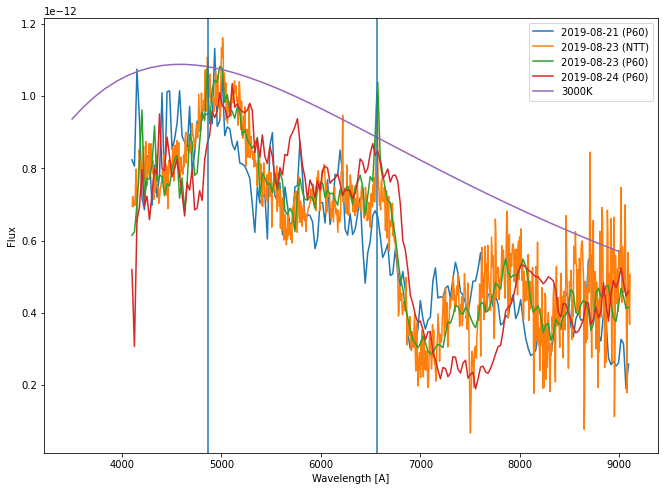

In [21]:
plt.figure(figsize=(11,8))

idx = spec1['wavelength'] > 4100
plt.plot(spec1['wavelength'][idx], spec1['wavelength'][idx]*spec1['flux'][idx]*1.4, label='2019-08-21 (P60)')

idx = spec2['wavelength'] > 4100
plt.plot(spec2['wavelength'][idx], spec2['wavelength'][idx]*spec2['flux'][idx], label='2019-08-23 (NTT)')

idx = spec3['wavelength'] > 4100
plt.plot(spec3['wavelength'][idx], spec3['wavelength'][idx]*spec3['flux'][idx], label='2019-08-23 (P60)')

idx = spec4['wavelength'] > 4100
plt.plot(spec4['wavelength'][idx], spec4['wavelength'][idx]*spec4['flux'][idx]*0.8, label='2019-08-24 (P60)')

# overplot BB
wave = np.linspace(3500, 9000)
sed = bb.bb(8000, 2e-23, wave)
plt.plot(wave, wave*sed, label='3000K')

plt.legend()
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')

for line in [6562, 4861]:
    plt.axvline(line)
plt.savefig('../paper/plots/tmp_plateau_spec_overlay.png')

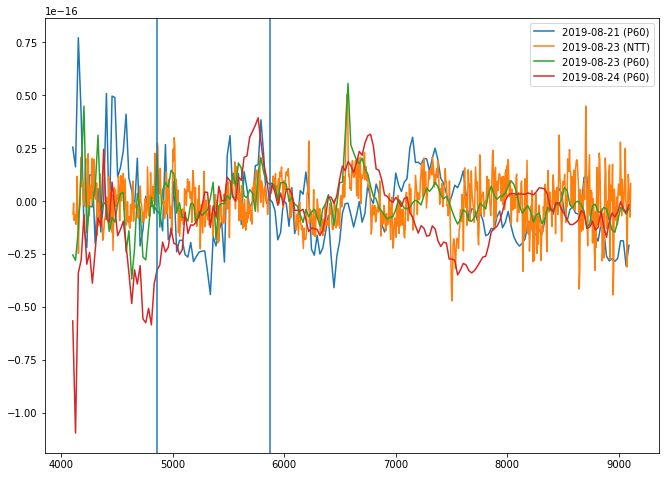

In [133]:
plt.figure(figsize=(11,8))
def remove_cont(wavelength, flux):
    #plt.plot(wavelength, flux)
    #wavelength_element = np.mean(np.diff(wavelength))
    #kernel_size = int(200/wavelength_element)+1
    #if kernel_size % 2  == 0:
    #    kernel_size += 1
    #flux_smoothed = signal.medfilt(flux, kernel_size)
    #plt.plot(wavelength, flux_smoothed)
    ## construct a smoothing spline
    # params:
    # order k
    k = 5
    
    # construct spline knot points
    if wavelength.max() > 8000:
        t = [5000, 5500, 6000, 6500, 7000, 7500, 8000]
    elif wavelength.max() > 7000:
        t = [5000, 5700, 6500]
    elif wavelength.max() > 6000:
        t = [4500, 5000, 6000]
    else:
        raise ValueError('fail')
    t = np.r_[(wavelength[0],)*(k+1),
          t,
          (wavelength[-1],)*(k+1)]
    
    # compute spline coefficients
    #spl = make_lsq_spline(wavelength, flux_smoothed, t, k)
    
    
    # and compute the spline curve
    #spline = spl(wavelength)
    #plt.plot(wavelength, spline)
    idx = ~np.isnan(flux)
    spl = make_lsq_spline(wavelength[idx], flux[idx], t, k)
    spline = spl(wavelength)
    #plt.plot(wavelength, spline)
    
    return flux - spline, spline, spl

idx = spec2['wavelength'] > 4100
spec2_nocont, spec2_cont, cont_spl = remove_cont(spec2['wavelength'][idx], spec2['flux'][idx])

idx = spec1['wavelength'] > 4100
plt.plot(spec1['wavelength'][idx], spec1['flux'][idx]*1.4 - cont_spl(spec1['wavelength'][idx]), label='2019-08-21 (P60)')

idx = spec2['wavelength'] > 4100
plt.plot(spec2['wavelength'][idx], spec2['flux'][idx] - cont_spl(spec2['wavelength'][idx]), label='2019-08-23 (NTT)')

idx = spec3['wavelength'] > 4100
plt.plot(spec3['wavelength'][idx], spec3['flux'][idx] - cont_spl(spec3['wavelength'][idx]), label='2019-08-23 (P60)')

idx = spec4['wavelength'] > 4100
plt.plot(spec4['wavelength'][idx], spec4['flux'][idx]*0.75 - cont_spl(spec4['wavelength'][idx]), label='2019-08-24 (P60)')

plt.legend()
plt.axvline(x=5876, label='He I')
plt.axvline(x=4861, label='Hbeta')

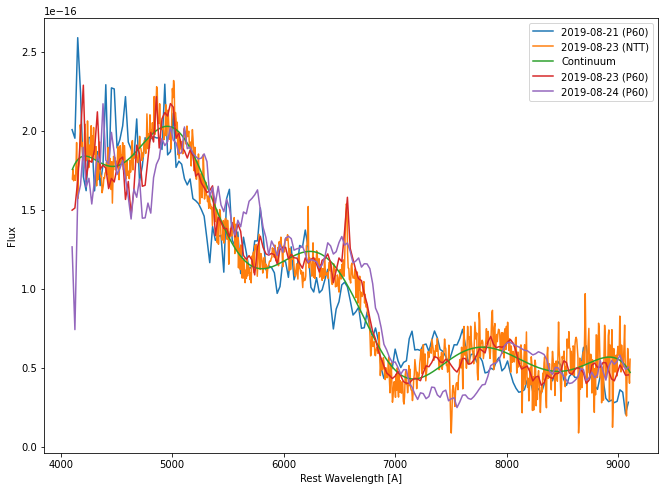

In [129]:
plt.figure(figsize=(11,8))

idx = spec1['wavelength'] > 4100
plt.plot(spec1['wavelength'][idx], spec1['flux'][idx]*1.4, label='2019-08-21 (P60)')

idx = spec2['wavelength'] > 4100
plt.plot(spec2['wavelength'][idx], spec2['flux'][idx], label='2019-08-23 (NTT)')

plt.plot(spec2['wavelength'][idx], cont_spl(spec2['wavelength'][idx]), label='Continuum')

idx = spec3['wavelength'] > 4100
plt.plot(spec3['wavelength'][idx], spec3['flux'][idx], label='2019-08-23 (P60)')

idx = spec4['wavelength'] > 4100
plt.plot(spec4['wavelength'][idx], spec4['flux'][idx]*0.8, label='2019-08-24 (P60)')



plt.legend()
plt.xlabel('Rest Wavelength [A]')
plt.ylabel('Flux')

#for line in [6562, 4861]:
#    plt.axvline(line)
plt.savefig('../paper/plots/tmp_plateau_spec_overlay.png')

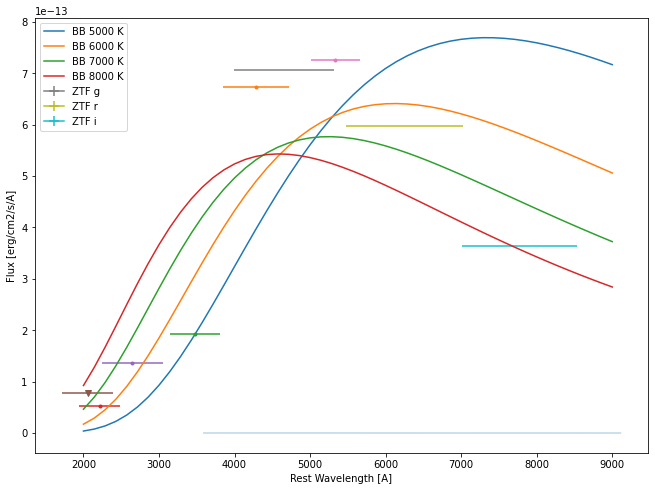

In [26]:
plt.figure(figsize=(11,8))

idx = spec2['wavelength'] > 2000
plt.plot(spec2['wavelength'][idx], spec2['flux'][idx]*0.75, alpha=0.3)

# select uvot photometry
idx = uvot['JD'] < 2458719

for band in np.unique(uvot['FILTER']):
    idx2 = np.logical_and(idx, uvot['FILTER'] == band)
    if np.count_nonzero(idx2) < 1:
        continue
    mag = uvot['AB_MAG'][idx2][0]
    lim_mag = uvot['AB_MAG_LIM'][idx2][0]
    mean_wave, zp_flux, width = UVOT_FILTERS[band]
    if mag > lim_mag:
        mag = lim_mag
        w = mean_wave/(1+redshift)
        plt.errorbar(w, w * zp_flux * 10**(-mag/2.5), marker='v', xerr=width/2)
    else:
        flux = zp_flux * 10**(-mag/2.5)
        flux_err = uvot['AB_MAG_ERR'][idx2][0] * flux / 1.087
        w = mean_wave/(1+redshift)
        plt.errorbar(w, w*flux, marker='.', xerr=width/2, yerr=flux_err)
    #mag -= 2*uvot['AB_MAG_ERR'][idx2][0]
    
# select ztf photometry
idx = np.logical_and(ztflc['obsmjd'] > 58718, ztflc['obsmjd'] < 58719)
for band in 'gri':
    idx2 = np.logical_and(idx, ztflc['filter'] == ('ZTF_%s' % band))
    #print(band, np.count_nonzero(idx2))
    mean_wave, zp_flux, width = ZTF_FILTERS[band]
    mag = ztflc['mag'][idx2][0]
    flux = zp_flux * 10**(-mag/2.5)
    flux_err = ztflc['rel_err'][idx2]*flux
    w = mean_wave/(1+redshift)
    plt.errorbar(w, w*flux, xerr=width/2, label='ZTF %s' % band, yerr=flux_err)
    
for band in 'gri':
    row = ztfint.iloc[2]
    mean_wave, zp_flux, width = ZTF_FILTERS[band]
    mag = row['mag_"%s"_ZTF' % band]
    flux = zp_flux * 10**(-mag/2.5)
    #plt.errorbar(mean_wave/(1+redshift), flux, xerr=width/2, label='ZTF %s' % band)

#for mean_wave, zp_flux in
for temp in [5000, 6000, 7000, 8000]:
    waves = np.linspace(2000, 9000)
    flux = bb.bb(temp, 1, waves)
    plt.plot(waves, waves*flux/np.nanmean(flux)/12e15, label='BB %d K' % temp)
plt.legend()
plt.xlabel('Rest Wavelength [A]')
plt.ylabel('Flux [erg/cm2/s/A]')
plt.savefig('../paper/plots/tmp_plateau_sed.png')

B 1
U 1
UVM2 1
UVW1 1
UVW2 1
V 1


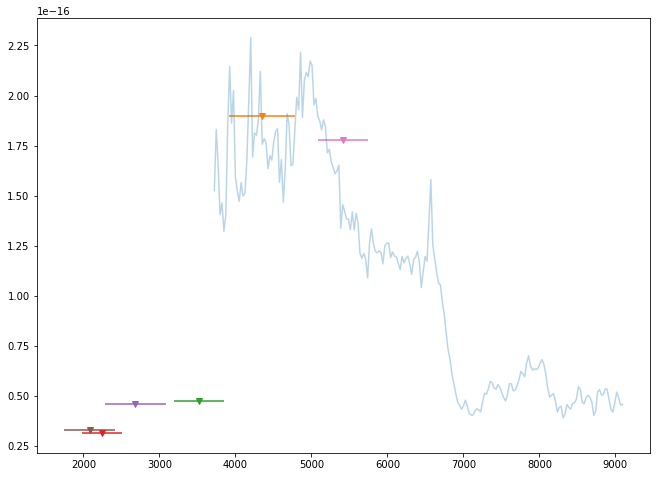

In [26]:
plt.figure(figsize=(11,8))

idx = spec3['wavelength'] > 3000
plt.plot(spec3['wavelength'][idx], spec3['flux'][idx], alpha=0.3)

# select uvot photometry
idx = np.logical_and(uvot['JD'] >= 2458719, uvot['JD'] < 2458720)

for band in np.unique(uvot['FILTER']):
    idx2 = np.logical_and(idx, uvot['FILTER'] == band)
    print(band, np.count_nonzero(idx2))
    if np.count_nonzero(idx2) < 1:
        continue
    mag = uvot['AB_MAG'][idx2][0]
    lim_mag = uvot['AB_MAG_LIM'][idx2][0]
    if mag > lim_mag:
        mag = lim_mag
    mean_wave, zp_flux, width = UVOT_FILTERS[band]
    plt.errorbar(mean_wave, zp_flux * 10**(-mag/2.5), marker='v', xerr=width/2)

#for mean_wave, zp_flux in
plt.savefig('../paper/plots/tmp_plateau_sed.png')

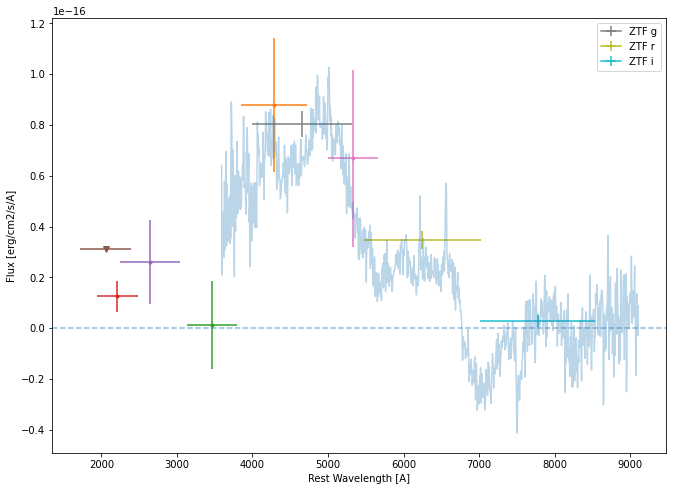

In [25]:
# Idea: Subtract a BB of around 8000K
plt.figure(figsize=(11,8))

bb_temp = 6000
bb_waves = np.linspace(2000, 9000)
bb_flux = bb.bb(bb_temp, 1, bb_waves)
bb_mean_flux = 1/np.nanmax(bb_flux)/14e15


idx = spec2['wavelength'] > 3000
bb_flux = bb.bb(bb_temp, 1, spec2['wavelength'][idx])
plt.plot(spec2['wavelength'][idx], spec2['flux'][idx]*0.75 - bb_flux * bb_mean_flux, alpha=0.3)

# select uvot photometry
idx = uvot['JD'] < 2458719



for band in np.unique(uvot['FILTER']):
    idx2 = np.logical_and(idx, uvot['FILTER'] == band)
    if np.count_nonzero(idx2) < 1:
        continue
    mag = uvot['AB_MAG'][idx2][0]
    lim_mag = uvot['AB_MAG_LIM'][idx2][0]
    mean_wave, zp_flux, width = UVOT_FILTERS[band]
    
    bb_flux_flt = bb.bb(bb_temp, 1, mean_wave) * bb_mean_flux
    
    
    if mag > lim_mag:
        mag = lim_mag
        plt.errorbar(mean_wave/(1+redshift), zp_flux * 10**(-mag/2.5) - bb_flux_flt, marker='v', xerr=width/2)
    else:
        flux = zp_flux * 10**(-mag/2.5)
        flux_err = uvot['AB_MAG_ERR'][idx2][0] * flux / 1.087
        plt.errorbar(mean_wave/(1+redshift), flux - bb_flux_flt, marker='.', xerr=width/2, yerr=flux_err)
    #mag -= 2*uvot['AB_MAG_ERR'][idx2][0]
    
# select ztf photometry
idx = np.logical_and(ztflc['obsmjd'] > 58718, ztflc['obsmjd'] < 58719)
for band in 'gri':
    idx2 = np.logical_and(idx, ztflc['filter'] == ('ZTF_%s' % band))
    #print(band, np.count_nonzero(idx2))
    mean_wave, zp_flux, width = ZTF_FILTERS[band]
    mag = ztflc['mag'][idx2][0]
    flux = zp_flux * 10**(-mag/2.5)
    flux_err = ztflc['rel_err'][idx2]*flux
    
    bb_flux_flt = bb.bb(bb_temp, 1, mean_wave) * bb_mean_flux
    
    plt.errorbar(mean_wave/(1+redshift), flux - bb_flux_flt, xerr=width/2, label='ZTF %s' % band, yerr=flux_err)
    
for band in 'gri':
    row = ztfint.iloc[2]
    mean_wave, zp_flux, width = ZTF_FILTERS[band]
    mag = row['mag_"%s"_ZTF' % band]
    flux = zp_flux * 10**(-mag/2.5)
    #plt.errorbar(mean_wave/(1+redshift), flux, xerr=width/2, label='ZTF %s' % band)

#for mean_wave, zp_flux in
#for temp in [5000, 6000, 7000, 8000]:
#    waves = np.linspace(2000, 9000)
#    flux = bb.bb(temp, 1, waves)
#    plt.plot(waves, flux/np.nanmax(flux)/14e15, label='BB %d K' % temp)
plt.legend()
plt.xlabel('Rest Wavelength [A]')
plt.ylabel('Flux [erg/cm2/s/A]')

plt.axhline(ls='--', alpha=0.5)

plt.savefig('../paper/plots/tmp_plateau_sed_subtracted.png')